# MIMIQ Demo – Entanglement Dynamics in Quantum Quenches

**QPerfect 2025**  
[https://qperfect.io/](https://qperfect.io/)  

The interactive version of this demo can be found at ...  

## Introduction and Context  

Arguably, one of the most promising use cases for universal digital quantum computers is the simulation of quantum many-body dynamics [S. Lloyd, Science 273, 1073 (1996), https://doi.org/10.1126/science.273.5278.1073 ]. For researchers working on quantum many-body problems in physics or chemistry, it can thus be valuable to start formulating a problem in a quantum circuit language. This way the code can be run on real quantum computers in the future. In addition, with MIMIQ being a universal emulator for quantum circuits, the problems can then already been tackled today.  

In two aspects, MIMIQ goes clearly beyond what real quantum computers can do today: i) **Higher fidelities and larger scale** – MIMIQ incorporates advances in classical algorithm development of over 30 years; ii) **Direct access to observables** – Unlike real quantum computers that require costly circuit repetition and sampling, MIMIQ provides direct access to observables (single- or multi-qubit), amplitudes, entanglement properties, ... we call it “god mode".

The goal of this demo is to demonstrate how to use MIMIQ in practice to conduct research on a recent topic in quantum many-body theory:  

### Entanglement Entropy and complexity of a quantum state  

Entanglement is a key concept of fundamental interest in quantum many-body theory, for example useful for characterizing quantum phases of matter. In addition, large-scale entanglement is also a fundamental resource for quantum computations and simulations. This is very easy to understand. Consider the following quantum state of *n* qubits:  

$$
|\psi_{\rm PS}\rangle =|\phi_0\rangle \otimes |\phi_1\rangle \otimes |\phi_2\rangle \otimes \dots \otimes  |\phi_{n-1}\rangle,
$$

where $|\phi_i\rangle = c^{[i]}_0 |0_i\rangle +  c^{[i]}_1 |1_i\rangle $ is a state of qubit *i*. The many-body state $|\psi_{\rm PS}\rangle $ is a **product state** and does not feature any entanglement by definition, i.e. the bipartite von Neumann entanglement entropy (VNE) of $|\psi_{\rm PS}\rangle$ vanishes, $S_{A} = 0$. Here $S_{A}$ is the VNE for a bipartition of the two qubits into two blocks $A$ and $B$, and for product states $S_{A} = 0$ for all such possible bi-partitions. From a computational standpoint, the absence of entanglement allows for an efficient classical representation of the state, here requiring only $2n$ parameters ($c^{[i]}_{0,1}$ for $i = 0,\dots,n-1$), a number scaling linearly with $n$. 

MIMIQ uses **matrix product states (MPS)** (see U. Schollwöck, Ann. Phys. 326, 96 (2011), https://doi.org/10.1016/j.aop.2010.09.012 for a review). An MPS can be thought of as a generalization of product states using a larger number of parameters to describe a state. In contrast to a product state, an MPS can represent states with a controllable amounts of entanglement. In particualr, the amount of VNE for any bi-partition is controlled with a single parameter, the **bond-dimension cutoff**, $\chi$. An upper bound of VNE is given by $S_{A} \leq \log_2 (\chi)$. In practice, this upper bound can be much smaller than the hypothetical maximally entanglement present in the system ($S_{A} \leq n/2$ for $n$ qubits), nevertheless the MPS may be big enought to capture all physics of interest. Note that a product state is simply a special case of an MPS with $\chi = 1$.

The key insight to keep in mind is: It is **not** the number of qubits $n$ that make a state difficult to represent in classical memory. It is the MPS **bond dimension** $\chi$ that determines the complexity of the state. The more entanglement appears in some quantum dynamics, the larger $\chi$ needs to be. Naturally, this has led to an important research question in quantum many-body theory over the past years: **How does entanglement grow over time?**  

## Quench Dynamics in Transverse Ising Models: A Closer Look  

Here we focus on so-called **quantum quench** dynamics in a transverse Ising model, where we study entanglement growth after a sudden change of a system parameter. The general idea is to use a violent quench of one parameter such that the system is take far out of equilibrium initially, leading to sub-sequent rapid build-up of entanglement.

Our transverse Ising model has the following Hamiltonian:

   $$
   \hat H = \sum_{i<j} J_{ij} \hat \sigma_i^z \hat \sigma_j^z + B \sum_i \hat \sigma_i^x
   $$  

Here, $\hat \sigma_i^{x,z}$ are usual Pauli matrices, and this model includes an interaction matrix $J_{ij}$ and a transverse field of strength $B$. We call it a spin-1/2 model, by identifying the two spin states as qubit states $|\!\uparrow\rangle = |0\rangle$ and $|\!\downarrow\rangle = |1\rangle$. Let's consider a situation where we take a system that is in the equilibrium ground state for times $t<0$ for an infinite negatvie transverse field $B(t<0) = -\infty$. This ground-state is a product state given by $|\psi_{\rm PS}\rangle =|+_0\rangle \otimes |+_1\rangle  \otimes \dots \otimes  |+_{n-1}\rangle$, where $|+\rangle$ denotes the positive eigenenstate of $\hat \sigma^x_i$, $|+_i\rangle = (|0\rangle + |1\rangle)/\sqrt(2)$. We can create this state by applying a series of Hadamard gates to a quantum register initialized in the 0 states.


MIMIQ provides built-in tools to set up and simulate entanglement growth in quenched systems.  

## MIMIQ Features Used in This Demo  

- **Entanglement entropy calculations**  
- **Expectation values of observables**  
- **Rotation Gates**
- **Simulation of models with long-range connectivity**  

# MIMIQ implementation

## Nearest Neigbour Interaction

First we want to simulate entanglement dynamics for nearest neigbour interactions in the Ising Hamiltonian

### Let's begin by importing the necessary packages and establishing a connection to the MIMIQ service.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mimiqcircuits import *
conn = MimiqConnection().connect()

### To Study entanglement dynamics, we define the following parameters:

n  → Number of qubits in the system.

B  → Strength of the transverse field in the Ising model.

J  → Coupling strength for the interaction terms.

dt  → Time step for Trotterization.

steps → Number of discrete time evolution steps.

tvec  → Time vector representing evolution times.

In [2]:
n = 50
B = 1
J = 1
dt = 0.1
steps = 50
tvec = np.linspace(0, dt * steps, steps) 

### Next we will start to implement time evolution, we use **Trotter decomposition**, which approximates the evolution operator.
  
#### Trotter Decomposition Idea  

- Decompose evolution into smaller time steps.  
 
#### Commonly Used Orders are:

1. **1st- and 2nd-order Trotterization** – Provides basic approximations.  
2. **4th-order Trotterization** – The "sweet spot" for accuracy vs. efficiency. 

We can map the evolution operator onto a sequence of one- and two-qubit rotation gates. To implement Trotterization efficiently, we decompose the evolution into two fundamental sweeps:

1. Left sweep – Evolves the transverse field in a forward direction.
2. Right sweep – Evolves the transverse field in a backward direction.

In [47]:
def lsweep(circuit, dt):
    for nn in range(n - 1):
        circuit.push(GateRX(2 * B * dt), nn)
        circuit.push(GateRZZ(2 * J * dt), nn, nn + 1)
    circuit.push(GateRX(2 * B * dt), n - 1)

In [48]:
def rsweep(circuit, dt):
    circuit.push(GateRX(2 * B * dt), n - 1)
    for nn in reversed(range(n - 1)):
        circuit.push(GateRZZ(2 * J * dt), nn, nn + 1)
        circuit.push(GateRX(2 * B * dt), nn)

### By alternating these sweeps, we can construct higher-order Trotterization methods to improve the accuracy of the simulation.

### First-Order Trotterization (trotter1)

In [49]:
def trotter1(circuit):
    lsweep(circuit, dt)

### Second-Order Trotterization (trotter2)

In [50]:
def trotter2(circuit):
    lsweep(circuit, dt / 2)
    rsweep(circuit, dt / 2)

### Fourth-Order Trotterization (trotter4)
Uses an alternating sequence of left and right sweeps to increase accuracy.

In [51]:
def trotter4(circuit):
        
    lsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    rsweep(circuit, -dt / 6)
    lsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    lsweep(circuit, -dt / 6)
    rsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)

### Now, we can start creating our quantum circuit. We use fourth-order Trotterization, which improves accuracy by systematically alternating left and right sweeps with carefully adjusted time steps. This allows us to better approximate the time evolution.

#### To construct the circuit

1. First apply Hadamard gates to each qubit, preparing an equal superposition state.
2. At each step, we compute the Von Neumann entropy at the midpoint to track entanglement growth over time.
3. Trotterized evolution – Using fourth-order Trotterization.



In [55]:
def prepare_circuit():
    
    circuit = Circuit()
    for nn in range(n):
        circuit.push(GateH(), nn)
        
    for ss in range(steps):
        circuit.push(VonNeumannEntropy(), n // 2, ss)
        trotter4(circuit)
     
    return circuit

### Now we are ready to simulate our circuit by **MPS** method of **MIMIQ-Simulator**. We write a method (simulate) and return the job ID with this method

In [56]:
def simulate(bonddim):
    circuit = prepare_circuit()
    job = conn.execute(circuit, bonddim=bonddim, algorithm="mps")
    return job

### Running the Simulation with Different Bond Dimensions

To systematically analyze the impact of bond dimension on simulation performance, we execute our circuit across multiple bond dimension values, submitting the corresponding jobs to the MIMIQ server. We organize the results in a structured dictionary, ensuring efficient storage and retrieval.

In [57]:
bonddim_values = [16, 32, 64, 128]

job_data = {}  
for bonddim in bonddim_values:
    job_id = simulate(bonddim)
    job_data[bonddim] = job_id
    print(f"Submitted job for bonddim={bonddim}, Job ID: {job_id}")

Submitted job for bonddim=16, Job ID: 67becb29f4cc5c2f9b611adf
Submitted job for bonddim=32, Job ID: 67becb2bf4cc5c2f9b611b98
Submitted job for bonddim=64, Job ID: 67becb2ef4cc5c2f9b611c51
Submitted job for bonddim=128, Job ID: 67becb31f4cc5c2f9b611db6


### Now, we retrieve the simulation job IDs from the MIMIQ server and extracting the Von Neumann entropy and fidelity for different bond dimensions and store the results in different dictionaries.

In [58]:
von_neumann_entropy = {}
fidelities = {}

for bonddim, job_id in job_data.items():
    print(f"Fetching results for bonddim={bonddim}, Job ID: {job_id}...")
    res = conn.get_result(job_id)

    von_neumann_entropy[bonddim] = np.abs(res.zstates[0])
    fidelities[bonddim] = res.fidelities  

Fetching results for bonddim=16, Job ID: 67becb29f4cc5c2f9b611adf...
Fetching results for bonddim=32, Job ID: 67becb2bf4cc5c2f9b611b98...
Fetching results for bonddim=64, Job ID: 67becb2ef4cc5c2f9b611c51...
Fetching results for bonddim=128, Job ID: 67becb31f4cc5c2f9b611db6...


Now we are ready to plot our results for making it easy we save the results in a list format

In [59]:
bonddim_values = list(job_data.keys())
fidelity_list = [fidelities[bd] for bd in bonddim_values]

### Define unique colors and markers for different bonddim values

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
markers = ['o', 's', 'D', '^', 'v', 'p']

### Here is our plotted results for showing Von Neumann Entropy vs Time  for different Bond Dimensions

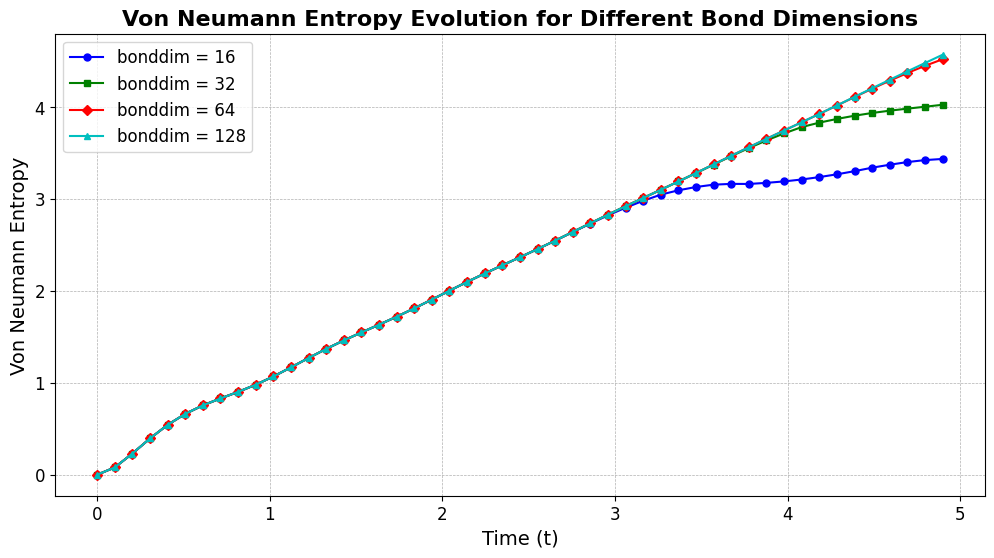

In [60]:

plt.figure(figsize=(12, 6))
for i, bonddim in enumerate(bonddim_values):
    plt.plot(tvec[:-1], von_neumann_entropy[bonddim][:-1], 
             marker=markers[i % len(markers)], linestyle='-', 
             color=colors[i % len(colors)], label=f"bonddim = {bonddim}", markersize=5)

plt.xlabel("Time (t)", fontsize=14)
plt.ylabel("Von Neumann Entropy", fontsize=14)
plt.title("Von Neumann Entropy Evolution for Different Bond Dimensions", fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc="best")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("von_neumann_entropy_nn.png", dpi=300, bbox_inches='tight')
plt.show()

### We also plot Fidelity vs Bond Dimension

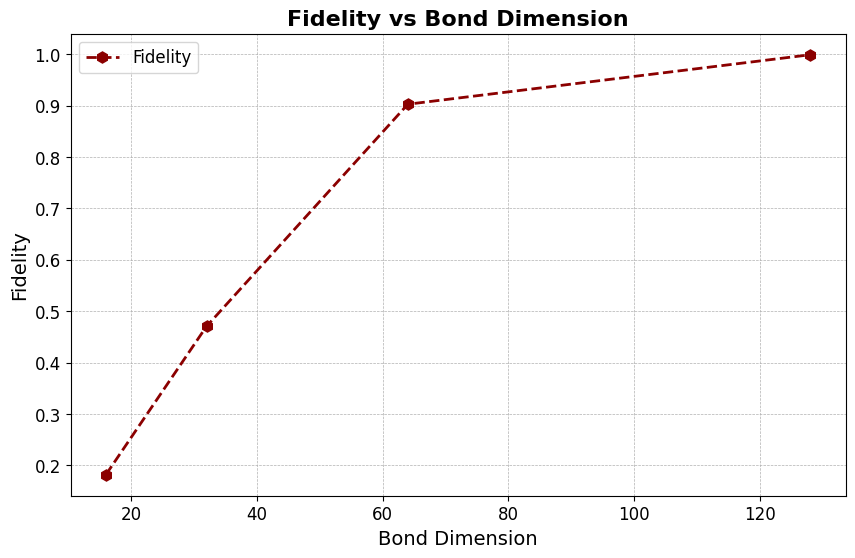

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(bonddim_values, fidelity_list, 
         marker='h', linestyle='--', color='darkred', 
         markersize=8, linewidth=2, label="Fidelity")

plt.xlabel("Bond Dimension", fontsize=14)
plt.ylabel("Fidelity", fontsize=14)
plt.title("Fidelity vs Bond Dimension", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("bonddim_nn.png", dpi=300, bbox_inches='tight')
plt.show()

# Going further with MIMIQ
## Incorporating Long-Range Interactions

To study the effect of long-range interactions, we modify our **Left** and **Right Sweeps** to include interactions between all qubits instead of just nearest neighbors. The rest of the process remains the same as in the nearest-neighbor case.

### Introducing Distance-Dependent Interactions

To incorporate long-range connectivity, we introduce the **alpha parameter (α)**, which controls how the interaction strength decays with distance. The coupling strength **Jij** between qubits **i** and **j** is defined as:

$$
J_{ij} = \frac{J}{\text{dist}(i, j)^{\alpha}}
$$

where **dist(i, j)** represents the absolute distance between qubits **i** and **j**. This modification ensures that the interaction strength decreases as the qubit separation increases, mimicking physical systems with power-law interaction decay.


### For doing this we need to define parameter α

### Set α = 3

In [ ]:
alpha = 3

### Modifing Trotterization Methods
- Introduces **long-range two-qubit interactions** (*RZZ gates*) for all pairs based on the distance-dependent coupling.
- By introducing **long-range interactions**, we extend our simulation beyond the nearest-neighbor case, allowing us to study the effects of **power-law decaying interactions** on entanglement growth and quantum dynamics.

In [35]:
def lsweep(circuit, dt):
    for i in (range(n-1)):
        circuit.push(GateRX(2 * B * dt), i)
        for j in range(i + 1, n):
            dist = abs(i - j)
            Jij = J / (dist ** alpha)
            param = 2 * Jij * dt
            circuit.push(GateRZZ(param), i, j)
    circuit.push(GateRX(-2 * B * dt), n-1)
    
            
def rsweep(circuit, dt):
    circuit.push(GateRX(-2 * B * dt), n-1)
    for i in reversed(range(n-1)):
        for j in reversed(range(i + 1, n)):
            dist = abs(i - j)
            Jij = J / (dist ** alpha)
            param = 2 * Jij * dt
            circuit.push(GateRZZ(param), i, j)
        circuit.push(GateRX(2 * B * dt), i)

### Defining Fourth Orders Trotterization methods

In [36]:
def trotter4(circuit):
    lsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    rsweep(circuit, -dt / 6)
    lsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)
    lsweep(circuit, -dt / 6)
    rsweep(circuit, dt / 12)
    lsweep(circuit, dt / 12)
    rsweep(circuit, dt / 12)

### Preparing circuit for long-range interaction

In [ ]:
def prepare_circuit():
    
    circuit = Circuit()
    for nn in range(n):
        circuit.push(GateH(), nn)
        
    for ss in range(steps):
        circuit.push(VonNeumannEntropy(), n // 2, ss)
        trotter4(circuit)
     
    return circuit

### Again we are ready to simulate our circuit by mps method of MIMIQ-Simulator. We write a method (**simulate**) and return the job ID with this method:

In [37]:
def simulate(bonddim):
    circuit = prepare_circuit()
    job = conn.execute(circuit, bonddim=bonddim, algorithm="mps")
    return job

### Now we run our simulation again for different bond dimensions like in the nearest neigbour case:

In [ ]:
bonddim_values = [16, 32, 64, 128] 
job_data = {}  
for bonddim in bonddim_values:
    job_id = simulate( bonddim)
    job_data[bonddim] = job_id
    print(f"Submitted job for bonddim={bonddim}, Job ID: {job_id}")

Submitted job for bonddim=16, Job ID: 67be4afcf4cc5c2f9b5dd5b0
Submitted job for bonddim=32, Job ID: 67be4b42f4cc5c2f9b5dd8f2
Submitted job for bonddim=64, Job ID: 67be4b89f4cc5c2f9b5ddb6d
Submitted job for bonddim=128, Job ID: 67be4bd5f4cc5c2f9b5dde07


### We retrieve the results and save them in the dictionaries and extract Von Neumann Entropy and fidelity from simulator result:

In [ ]:
von_neumann_entropy = {}
fidelities = {}
for bonddim, job_id in job_data.items():
    print(f"Fetching results for bonddim={bonddim}, Job ID: {job_id}...")
    res = conn.get_result(job_id)

    von_neumann_entropy[bonddim] = np.abs(res.zstates[0])
    fidelities[bonddim] = res.fidelities  


Fetching results for bonddim=16, Job ID: 67be4afcf4cc5c2f9b5dd5b0...
Fetching results for bonddim=32, Job ID: 67be4b42f4cc5c2f9b5dd8f2...
Fetching results for bonddim=64, Job ID: 67be4b89f4cc5c2f9b5ddb6d...
Fetching results for bonddim=128, Job ID: 67be4bd5f4cc5c2f9b5dde07...


### Convert to list for easy plotting

In [41]:
bonddim_values = list(job_data.keys())
fidelity_list = [fidelities[bd] for bd in bonddim_values]

### Define unique colors and markers for different bonddim values

In [42]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
markers = ['o', 's', 'D', '^', 'v', 'p']

### Now plotting Von Neumann Entropy vs Time 

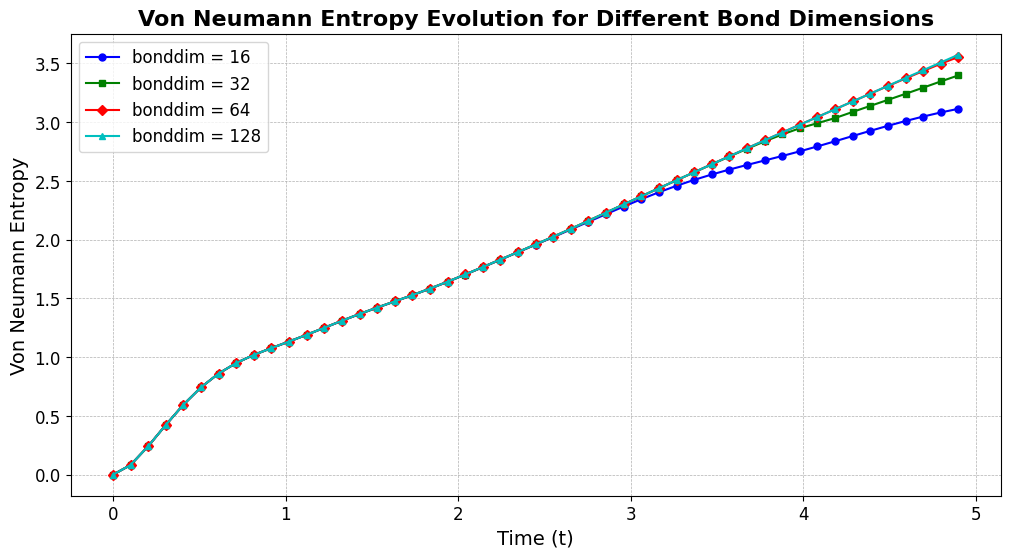

In [ ]:
plt.figure(figsize=(12, 6))
for i, bonddim in enumerate(bonddim_values):
    plt.plot(tvec[:-1], von_neumann_entropy[bonddim][:-1], 
             marker=markers[i % len(markers)], linestyle='-', 
             color=colors[i % len(colors)], label=f"bonddim = {bonddim}", markersize=5)

plt.xlabel("Time (t)", fontsize=14)
plt.ylabel("Von Neumann Entropy", fontsize=14)
plt.title("Von Neumann Entropy Evolution for Different Bond Dimensions", fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc="best")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("von_neumann_entropy_lr.png", dpi=300, bbox_inches='tight')
plt.show()


### And plotting Fidelity vs Bond Dimension 

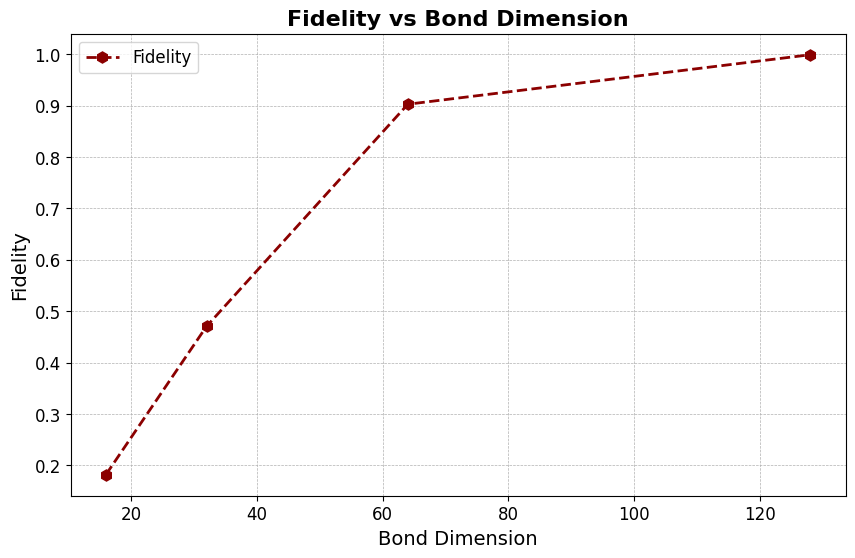

In [62]:
# PLOT 2: 
plt.figure(figsize=(10, 6))
plt.plot(bonddim_values, fidelity_list, 
         marker='h', linestyle='--', color='darkred', 
         markersize=8, linewidth=2, label="Fidelity")

plt.xlabel("Bond Dimension", fontsize=14)
plt.ylabel("Fidelity", fontsize=14)
plt.title("Fidelity vs Bond Dimension", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("bonddim_lr.png", dpi=300, bbox_inches='tight')
plt.show()


# Conclusion

In this study, we have explored how entanglement grows under different interaction regimes in the Ising Hamiltonian using **Trotterized time evolution**. Our results demonstrate distinct behaviors in entanglement dynamics depending on the nature of the interaction:

- **Nearest-neighbor interactions** lead to **linear growth** of entanglement entropy over time.
- **Long-range interactions** exhibit **logarithmic growth** in entanglement entropy, reflecting the broader connectivity of the system.